<a href="https://colab.research.google.com/github/kanadn/Machine-Learning-Practice/blob/master/Keras_Flowers_transfer_learning_(playground).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training on GPU will be fine for transfer learning as it is not a very demanding process.

## Imports

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.5.0


## Configuration

In [ ]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 5

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [ ]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

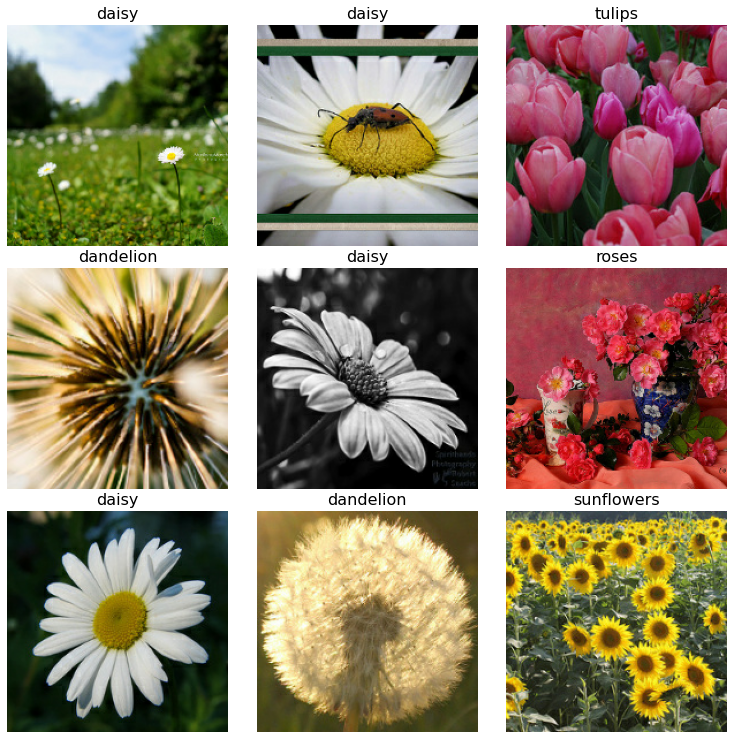

In [ ]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

## Model [WORK REQUIRED]
1. Start with a dummy single-layer model using one dense layer:
 * Use  a [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) model. The constructor takes a list of layers.
 * First, [`Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the pixel values of the the input image to a 1D vector so that a dense layer can consume it:<br/>
 `tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3])  # the first layer must also specify input shape`
 * Add a single [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers):<br/>
  `tf.keras.layers.Dense(5, activation='softmax')`
 * add the last bits and pieces with [model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#compile). For a classifier, you need `'sparse_categorical_crossentropy'` loss, `'accuracy'` in metrics and you can use the `'adam'` optimizer.

 **==>Train this model: not very good... but all the plumbing is in place.**

1. Instead of trying to figure out a better architecture, we will adapt a pretrained model to our data. Please remove all your layers to restart from scratch.
 * Instantiate a pre-trained model from `tf.keras.applications.*`
 You do not need its final softmax layer (`include_top=False`) because you will be adding your own. This code is already written in the cell below.<br/>
 * Use `pretrained_model` as your first "layer" in your Sequential model.
 * Follow with  [`tf.keras.layers.Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) or [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) to turn the data from the pretrained model into a flat 1D vector.
 * Add your [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers).

 **==>Train the model: you should be able to reach above 75% accuracy by training for 10 epochs**

1. You can try adding a second dense layer. Use 'relu' activation on all dense layers but the last one which must be 'softmax'. An additional layer ads trainable weights. It is unlikely to do much good here though, because our dataset is too small.

This technique is called "transfer learning". The pretrained model has been trained on a different dataset but its layers have still learned to recognize bits and pieces of images that can be useful for flowers. You are retraining the last layer only, the pretrained weights are frozen. With far fewer weights to adjust, it works with less data.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

# Single layer model-----------------------------
# model = tf.keras.Sequential([
#   tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3]), # the first layer must also specify input shape
#   tf.keras.layers.Dense(5, activation='softmax')
# ])

# Transfer learning-----------------------------
model = tf.keras.Sequential([
  pretrained_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
  optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy' 
)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training

In [ ]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/5
46/46 [==============================] - 38s 128ms/step - loss: 1.5481 - accuracy: 0.7884 - val_loss: 1.0142 - val_accuracy: 0.8319
Epoch 2/5
46/46 [==============================] - 4s 77ms/step - loss: 0.2781 - accuracy: 0.9395 - val_loss: 1.0538 - val_accuracy: 0.8493
Epoch 3/5
46/46 [==============================] - 4s 77ms/step - loss: 0.0770 - accuracy: 0.9810 - val_loss: 1.2173 - val_accuracy: 0.8478
Epoch 4/5
46/46 [==============================] - 4s 77ms/step - loss: 0.0505 - accuracy: 0.9840 - val_loss: 1.2803 - val_accuracy: 0.8449
Epoch 5/5
46/46 [==============================] - 3s 76ms/step - loss: 0.0565 - accuracy: 0.9861 - val_loss: 2.0608 - val_accuracy: 0.8159


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


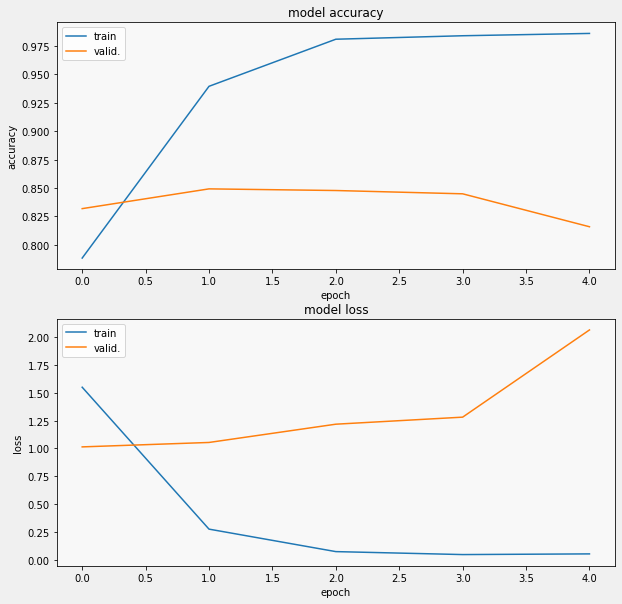

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

['tulips', 'roses', 'dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'tulips']


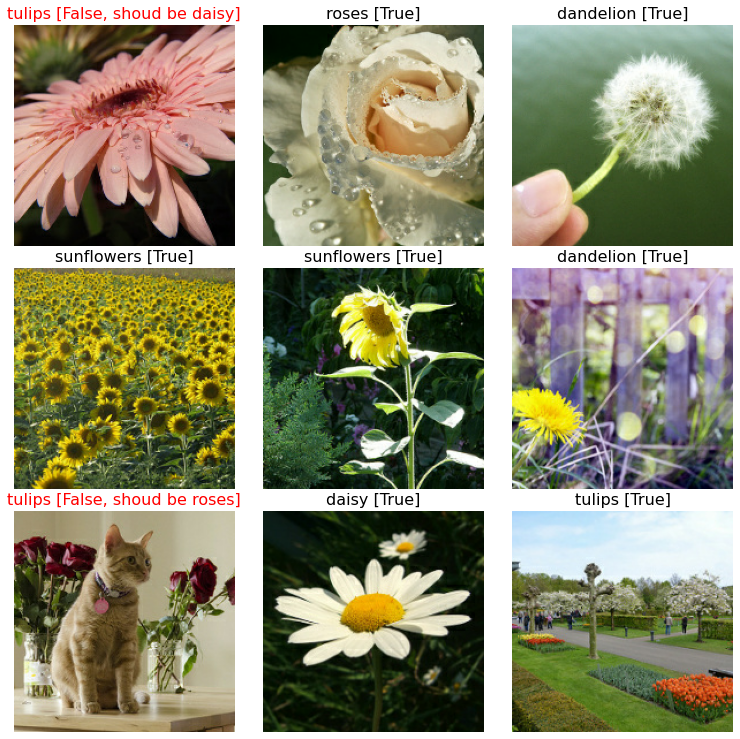

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
